<a href="https://colab.research.google.com/github/stanlead123/FinRL/blob/master/UltimateResult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FinRL: Compare ElegantRL, RLlib, and Stablebaselines3

## Install DRL libraries: FinRL, ElegantRL, RLlib

In [2]:
## install elegantrl library
!pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git
## install rllib/ray library
!pip install ray[default]
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/ElegantRL.git to /tmp/pip-req-build-35f9fdmz
  Running command git clone -q https://github.com/AI4Finance-LLC/ElegantRL.git /tmp/pip-req-build-35f9fdmz
  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-h329hgwt
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-h329hgwt
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-bwi5l_o_/pyfolio_4558a6fc770c44eeae74b003cfb6317c
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-bwi5l_o_/pyfolio_4558a6fc770c44eeae74b003cfb6317c


## Install additional packages

In [3]:
!pip install trading_calendars
!pip install alpaca_trade_api
!pip install ccxt
!pip install jqdatasdk
!pip install wrds

!pip install lz4
!pip install ray[tune]
!pip install tensorboardX
!pip install gputil

## Import packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use('Agg')
import datetime

from elegantrl.agent import *
from elegantrl.run import *
import torch 
import ray
from finrl.apps import config
# from finrl.neo_finrl.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline



/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


# Add Yahoo data processor code for editing purposes

Steps for adding/removing data cols
1. Make sure the YahooFinance class outputs it to the array -- This is done in df_to_array part
2. Add/Remove relevant piece in get_state of StockTradingEnv
3. Add/Remove relevant stock_dim sum pieces at start of StockTradingEnv

In [5]:
import pandas as pd
import yfinance as yf
import numpy as np
from stockstats import StockDataFrame as Sdf
import trading_calendars as tc
import pytz

class YahooFinanceProcessor():
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)
    Methods
    -------
    fetch_data()
        Fetches data from yahoo API
    """

    def __init__(self):
        pass
    
    def download_data(self, start_date: str, end_date: str, ticker_list: list,
                      time_interval: str) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------
        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        
        self.start = start_date
        self.end = end_date
        self.time_interval = time_interval
        
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        for tic in ticker_list:
            temp_df = yf.download(tic, start=start_date, end=end_date)
            temp_df["tic"] = tic
            data_df = data_df.append(temp_df)
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = [
                "date",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
                "tic",
            ]
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=['date','tic']).reset_index(drop=True)

        return data_df
    
    def clean_data(self, data) -> pd.DataFrame:
        
        df = data.copy()
        df = df.rename(columns={'date':'time'})
        time_interval = self.time_interval
        #get ticker list
        tic_list = np.unique(df.tic.values)
    
        #get complete time index
        trading_days = self.get_trading_days(start=self.start, end=self.end)
        if time_interval == '1D':
            times = trading_days
        elif time_interval == '1Min':
            times = []
            for day in trading_days:
                NY = 'America/New_York'
                current_time = pd.Timestamp(day+' 09:30:00').tz_localize(NY)
                for i in range(390):
                    times.append(current_time)
                    current_time += pd.Timedelta(minutes=1)
        else:
            raise ValueError('Data clean at given time interval is not supported for YahooFinance data.')
            
        #fill NaN data
        new_df = pd.DataFrame()
        for tic in tic_list:
            print (('Clean data for ') + tic)
            #create empty DataFrame using complete time index
            tmp_df = pd.DataFrame(columns=['open','high','low','close',
                                           'adjcp','volume'], 
                                  index=times)
            #get data for current ticker
            tic_df = df[df.tic == tic]
            #fill empty DataFrame using orginal data
            for i in range(tic_df.shape[0]):
                tmp_df.loc[tic_df.iloc[i]['time']] = tic_df.iloc[i]\
                    [['open','high','low','close','adjcp','volume']]
            
            #if close on start date is NaN, fill data with first valid close 
            #and set volume to 0.
            if str(tmp_df.iloc[0]['close']) == 'nan':
                print('NaN data on start date, fill using first valid data.')
                for i in range(tmp_df.shape[0]):
                    if str(tmp_df.iloc[i]['close']) != 'nan':
                        first_valid_close = tmp_df.iloc[i]['close']
                        first_valid_adjclose = tmp_df.iloc[i]['adjcp']
                        
                tmp_df.iloc[0] = [first_valid_close, first_valid_close, 
                                  first_valid_close, first_valid_close,
                                  first_valid_adjclose, 0.0]
                
            #fill NaN data with previous close and set volume to 0.
            for i in range(tmp_df.shape[0]):
                if str(tmp_df.iloc[i]['close']) == 'nan':
                    previous_close = tmp_df.iloc[i-1]['close']
                    previous_adjcp = tmp_df.iloc[i-1]['adjcp']
                    if str(previous_close) == 'nan':
                        raise ValueError
                    tmp_df.iloc[i] = [previous_close, previous_close, previous_close,
                                      previous_close, previous_adjcp, 0.0]
            
            #merge single ticker data to new DataFrame
            tmp_df = tmp_df.astype(float)
            tmp_df['tic'] = tic
            new_df = new_df.append(tmp_df)
        
            print (('Data clean for ') + tic + (' is finished.'))
            
        #reset index and rename columns
        new_df = new_df.reset_index()
        new_df = new_df.rename(columns={'index':'time'})
        
        print('Data clean all finished!')
        
        return new_df
    
    def add_technical_indicator(self, data, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(by=['tic','time'])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator['tic'] = unique_ticker[i]
                    temp_indicator['time'] = df[df.tic == unique_ticker[i]]['time'].to_list()
                    indicator_df = indicator_df.append(
                        temp_indicator, ignore_index=True
                    )
                except Exception as e:
                    print(e)
            df = df.merge(indicator_df[['tic','time',indicator]],on=['tic','time'],how='left')
        df = df.sort_values(by=['time','tic'])
        return df

    def add_turbulence(self, data):
        """
        add turbulence index from a precalcualted dataframe
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df)
        df = df.merge(turbulence_index, on="time")
        df = df.sort_values(["time", "tic"]).reset_index(drop=True)
        return df

    def calculate_turbulence(self, data, time_period = 252):
        """calculate turbulence index based on dow 30"""
        # can add other market assets
        df = data.copy()
        df_price_pivot = df.pivot(index="time", columns="tic", values="close")
        # use returns to calculate turbulence
        df_price_pivot = df_price_pivot.pct_change()

        unique_date = df.date.unique()
        # start after a year
        start = time_period
        turbulence_index = [0] * start
        # turbulence_index = [0]
        count = 0
        for i in range(start, len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            # use one year rolling window to calcualte covariance
            hist_price = df_price_pivot[
                (df_price_pivot.index < unique_date[i])
                & (df_price_pivot.index >= unique_date[i - time_period])
            ]
            # Drop tickers which has number missing values more than the "oldest" ticker
            filtered_hist_price = hist_price.iloc[hist_price.isna().sum().min():].dropna(axis=1)

            cov_temp = filtered_hist_price.cov()
            current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(filtered_hist_price, axis=0)
            #cov_temp = hist_price.cov()
            #current_temp=(current_price - np.mean(hist_price,axis=0))
            
            temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(
                current_temp.values.T
            )
            if temp > 0:
                count += 1
                if count > 2:
                    turbulence_temp = temp[0][0]
                else:
                    # avoid large outlier because of the calculation just begins
                    turbulence_temp = 0
            else:
                turbulence_temp = 0
            turbulence_index.append(turbulence_temp)

        turbulence_index = pd.DataFrame(
            {"time": df_price_pivot.index, "turbulence": turbulence_index}
        )
        return turbulence_index
    
    def add_vix(self, data):
        """
        add vix from yahoo finance
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df_vix = self.download_data(start_date= df.time.min(), 
                                    end_date= df.time.max(),
                                    ticker_list = ["^VIX"],
                                    time_interval = self.time_interval)
        df_vix = self.clean_data(df_vix)
        vix = df_vix[['time','adjcp']]
        vix.columns = ['time','vix']

        df = df.merge(vix, on="time")
        df = df.sort_values(["time", "tic"]).reset_index(drop=True)
        return df
    
    def df_to_array(self, df, tech_indicator_list, if_vix):
        """transform final df to numpy arrays"""
        unique_ticker = df.tic.unique()
        print(unique_ticker)
        if_first_time = True
        for tic in unique_ticker:
            if if_first_time:
                #price_array = df[df.tic==tic][['adjcp']].values
                price_array = df[df.tic==tic][['open', 'high', 'low', 'close', 'adjcp']].values
                tech_array = df[df.tic==tic][tech_indicator_list].values
                if if_vix:
                    turbulence_array = df[df.tic==tic]['vix'].values 
                else:
                    turbulence_array = df[df.tic==tic]['turbulence'].values 
                if_first_time = False
            else:
                #price_array = np.hstack([price_array, df[df.tic==tic][['adjcp']].values])
                price_array = np.hstack([price_array, df[df.tic==tic][['open', 'high', 'low', 'close', 'adjcp']].values])
                tech_array = np.hstack([tech_array, df[df.tic==tic][tech_indicator_list].values])
        assert price_array.shape[0] == tech_array.shape[0]
        assert tech_array.shape[0] == turbulence_array.shape[0]
        print('Successfully transformed into array -- Adams version')
        return price_array, tech_array, turbulence_array
        

    def get_trading_days(self, start, end):
        nyse = tc.get_calendar('NYSE')
        df = nyse.sessions_in_range(pd.Timestamp(start,tz=pytz.UTC),
                                    pd.Timestamp(end,tz=pytz.UTC))
        trading_days = []
        for day in df:
            trading_days.append(str(day)[:10])
    
        return trading_days

## My own yf downloader which take all adjusted prices automatically

In [6]:

class AdjustedYahooFinanceProcessor():
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)
    Methods
    -------
    fetch_data()
        Fetches data from yahoo API
    """

    def __init__(self):
        pass
    
    def download_data(self, start_date: str, end_date: str, ticker_list: list,
                      time_interval: str) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------
        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        
        self.start = start_date
        self.end = end_date
        self.time_interval = time_interval
        
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        for tic in ticker_list:
            temp_df = yf.download(tic, start=start_date, end=end_date, auto_adjust=True)
            temp_df["tic"] = tic
            data_df = data_df.append(temp_df)
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = [
                "date",
                "open",
                "high",
                "low",
                "close",
                "volume",
                "tic",
            ]
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=['date','tic']).reset_index(drop=True)

        return data_df
    
    def clean_data(self, data) -> pd.DataFrame:
        
        df = data.copy()
        df = df.rename(columns={'date':'time'})
        time_interval = self.time_interval
        #get ticker list
        tic_list = np.unique(df.tic.values)
    
        #get complete time index
        trading_days = self.get_trading_days(start=self.start, end=self.end)
        if time_interval == '1D':
            times = trading_days
        elif time_interval == '1Min':
            times = []
            for day in trading_days:
                NY = 'America/New_York'
                current_time = pd.Timestamp(day+' 09:30:00').tz_localize(NY)
                for i in range(390):
                    times.append(current_time)
                    current_time += pd.Timedelta(minutes=1)
        else:
            raise ValueError('Data clean at given time interval is not supported for YahooFinance data.')
            
        #fill NaN data
        new_df = pd.DataFrame()
        for tic in tic_list:
            print (('Clean data for ') + tic)
            #create empty DataFrame using complete time index
            tmp_df = pd.DataFrame(columns=['open','high','low','close','volume'], 
                                  index=times)
            #get data for current ticker
            tic_df = df[df.tic == tic]
            #fill empty DataFrame using orginal data
            for i in range(tic_df.shape[0]):
                tmp_df.loc[tic_df.iloc[i]['time']] = tic_df.iloc[i]\
                    [['open','high','low','close','volume']]
            
            #if close on start date is NaN, fill data with first valid close 
            #and set volume to 0.
            if str(tmp_df.iloc[0]['close']) == 'nan':
                print('NaN data on start date, fill using first valid data.')
                for i in range(tmp_df.shape[0]):
                    if str(tmp_df.iloc[i]['close']) != 'nan':
                        first_valid_close = tmp_df.iloc[i]['close']
                        #first_valid_adjclose = tmp_df.iloc[i]['adjcp']
                        
                tmp_df.iloc[0] = [first_valid_close, first_valid_close, 
                                  first_valid_close, first_valid_close,
                                  0.0]
                
            #fill NaN data with previous close and set volume to 0.
            for i in range(tmp_df.shape[0]):
                if str(tmp_df.iloc[i]['close']) == 'nan':
                    previous_close = tmp_df.iloc[i-1]['close']
                    #previous_adjcp = tmp_df.iloc[i-1]['adjcp']
                    if str(previous_close) == 'nan':
                        raise ValueError
                    tmp_df.iloc[i] = [previous_close, previous_close, previous_close,
                                      previous_close, 0.0]
            
            #merge single ticker data to new DataFrame
            tmp_df = tmp_df.astype(float)
            tmp_df['tic'] = tic
            new_df = new_df.append(tmp_df)
        
            print (('Data clean for ') + tic + (' is finished.'))
            
        #reset index and rename columns
        new_df = new_df.reset_index()
        new_df = new_df.rename(columns={'index':'time'})
        
        print('Data clean all finished!')
        
        return new_df
    
    def add_technical_indicator(self, data, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(by=['tic','time'])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator['tic'] = unique_ticker[i]
                    temp_indicator['time'] = df[df.tic == unique_ticker[i]]['time'].to_list()
                    indicator_df = indicator_df.append(
                        temp_indicator, ignore_index=True
                    )
                except Exception as e:
                    print(e)
            df = df.merge(indicator_df[['tic','time',indicator]],on=['tic','time'],how='left')
        df = df.sort_values(by=['time','tic'])
        return df

    def add_turbulence(self, data):
        """
        add turbulence index from a precalcualted dataframe
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df)
        df = df.merge(turbulence_index, on="time")
        df = df.sort_values(["time", "tic"]).reset_index(drop=True)
        return df

    def calculate_turbulence(self, data, time_period = 252):
        """calculate turbulence index based on dow 30"""
        # can add other market assets
        df = data.copy()
        df_price_pivot = df.pivot(index="time", columns="tic", values="close")
        # use returns to calculate turbulence
        df_price_pivot = df_price_pivot.pct_change()

        unique_date = df.date.unique()
        # start after a year
        start = time_period
        turbulence_index = [0] * start
        # turbulence_index = [0]
        count = 0
        for i in range(start, len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            # use one year rolling window to calcualte covariance
            hist_price = df_price_pivot[
                (df_price_pivot.index < unique_date[i])
                & (df_price_pivot.index >= unique_date[i - time_period])
            ]
            # Drop tickers which has number missing values more than the "oldest" ticker
            filtered_hist_price = hist_price.iloc[hist_price.isna().sum().min():].dropna(axis=1)

            cov_temp = filtered_hist_price.cov()
            current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(filtered_hist_price, axis=0)
            #cov_temp = hist_price.cov()
            #current_temp=(current_price - np.mean(hist_price,axis=0))
            
            temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(
                current_temp.values.T
            )
            if temp > 0:
                count += 1
                if count > 2:
                    turbulence_temp = temp[0][0]
                else:
                    # avoid large outlier because of the calculation just begins
                    turbulence_temp = 0
            else:
                turbulence_temp = 0
            turbulence_index.append(turbulence_temp)

        turbulence_index = pd.DataFrame(
            {"time": df_price_pivot.index, "turbulence": turbulence_index}
        )
        return turbulence_index
    
    def add_vix(self, data):
        """
        add vix from yahoo finance
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df_vix = self.download_data(start_date= df.time.min(), 
                                    end_date= df.time.max(),
                                    ticker_list = ["^VIX"],
                                    time_interval = self.time_interval)
        df_vix = self.clean_data(df_vix)
        vix = df_vix[['time','close']]
        vix.columns = ['time','vix']

        df = df.merge(vix, on="time")
        df = df.sort_values(["time", "tic"]).reset_index(drop=True)
        return df
    
    def df_to_array(self, df, tech_indicator_list, if_vix):
        """transform final df to numpy arrays"""
        unique_ticker = df.tic.unique()
        print(unique_ticker)
        if_first_time = True
        for tic in unique_ticker:
            if if_first_time:
                price_array = df[df.tic==tic][['open', 'high', 'low', 'close']].values
                tech_array = df[df.tic==tic][tech_indicator_list].values
                if if_vix:
                    turbulence_array = df[df.tic==tic]['vix'].values 
                else:
                    turbulence_array = df[df.tic==tic]['turbulence'].values 
                if_first_time = False
            else:
                price_array = np.hstack([price_array, df[df.tic==tic][['open', 'high', 'low', 'close']].values])
                tech_array = np.hstack([tech_array, df[df.tic==tic][tech_indicator_list].values])
        assert price_array.shape[0] == tech_array.shape[0]
        assert tech_array.shape[0] == turbulence_array.shape[0]
        print('Successfully transformed into array -- Adams Adjusted-version')
        return price_array, tech_array, turbulence_array
        

    def get_trading_days(self, start, end):
        nyse = tc.get_calendar('NYSE')
        df = nyse.sessions_in_range(pd.Timestamp(start,tz=pytz.UTC),
                                    pd.Timestamp(end,tz=pytz.UTC))
        trading_days = []
        for day in df:
            trading_days.append(str(day)[:10])
    
        return trading_days

In [7]:

data = yf.download("AAPL", start="2017-01-01", end="2017-04-30")
data.head()



[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.372362,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.341724,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.480770,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.787130,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.041647,134247600


In [8]:

data = yf.download("AAPL", start="2017-01-01", end="2017-04-30", auto_adjust=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,27.289880,27.414782,27.044789,27.372362,115127600
2017-01-04,27.301662,27.457201,27.278096,27.341724,84472400
2017-01-05,27.318161,27.539686,27.292238,27.480770,88774400
2017-01-06,27.520829,27.846046,27.447774,27.787130,127007600
2017-01-09,27.796556,28.145340,27.794201,28.041647,134247600


#Data Processor code for editing
Only changing YahooFinanceProcessor (elif line) -- Never edit this

In [9]:
from finrl.neo_finrl.data_processors.processor_alpaca import AlpacaProcessor as Alpaca
from finrl.neo_finrl.data_processors.processor_wrds import WrdsProcessor as Wrds
#from finrl.neo_finrl.data_processors.processor_yahoofinance import YahooFinanceProcessor as YahooFinance
import pandas as pd
import numpy as np

class DataProcessor():
    def __init__(self, data_source, **kwargs):
        if data_source == 'alpaca':
            
            try:
                API_KEY= kwargs.get('API_KEY')
                API_SECRET= kwargs.get('API_SECRET')
                APCA_API_BASE_URL= kwargs.get('APCA_API_BASE_URL')
                self.processor = Alpaca(API_KEY, API_SECRET, APCA_API_BASE_URL)
                print('Alpaca successfully connected')
            except:
                raise ValueError('Please input correct account info for alpaca!')
                
        elif data_source == 'wrds':
            self.processor = Wrds()
            
        elif data_source == 'yahoofinance':
            self.processor = YahooFinanceProcessor()

        elif data_source == 'adjustedyahoofinance':
          self.processor = AdjustedYahooFinanceProcessor()
        
        else:
            raise ValueError('Data source input is NOT supported yet.')
    
    def download_data(self, ticker_list, start_date, end_date, 
                      time_interval) -> pd.DataFrame:
        df = self.processor.download_data(ticker_list = ticker_list, 
                                          start_date = start_date, 
                                          end_date = end_date,
                                          time_interval = time_interval)
        return df
    
    def clean_data(self, df) -> pd.DataFrame:
        df = self.processor.clean_data(df)
        
        return df
    
    def add_technical_indicator(self, df, tech_indicator_list) -> pd.DataFrame:
        self.tech_indicator_list = tech_indicator_list
        df = self.processor.add_technical_indicator(df, tech_indicator_list)
        
        return df
    
    def add_turbulence(self, df) -> pd.DataFrame:
        df = self.processor.add_turbulence(df)
        
        return df
    
    def add_vix(self, df) -> pd.DataFrame:
        df = self.processor.add_vix(df)
        
        return df
    
    def df_to_array(self, df, if_vix) -> np.array:
        price_array,tech_array,turbulence_array = self.processor.df_to_array(df,
                                                self.tech_indicator_list,
                                                if_vix)
        #fill nan with 0 for technical indicators
        tech_nan_positions = np.isnan(tech_array)
        tech_array[tech_nan_positions] = 0
        
        return price_array,tech_array,turbulence_array

## Train

In [10]:
def train(start_date, end_date, ticker_list, data_source, time_interval, 
          technical_indicator_list, drl_lib, env, agent, if_vix = True,
          **kwargs):
    
    #fetch data
    DP = DataProcessor(data_source, **kwargs)

    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    print('\n Raw data \n', data.head())

    data = DP.clean_data(data)
    print('\n Clean data \n', data.head())
    
    # Add technical indicators
    data = DP.add_technical_indicator(data, technical_indicator_list)
    print('\n Technical indicators added \n', data.head())

    # Add vix/turbulence
    if if_vix:
        data = DP.add_vix(data)
    
    # Output arrays
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    
    print('Price array shape =', price_array.shape)
    print('Price array first entry:\n', price_array[0,])
    
    print('Tech array shape =', tech_array.shape)

    #read parameters
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':True}

    print('price array, tech array, turb array')
    print(price_array[:5,])
    print(tech_array[:5,])
    print(turbulence_array[:5,])

    env_instance = env(config=env_config)
    
    learning_rate = kwargs.get('learning_rate', 0.00025)
    batch_size = kwargs.get('batch_size', 2**7)
    gamma = kwargs.get('gamma', 0.99)
    seed = kwargs.get('seed', 312)
    total_timesteps = kwargs.get('total_timesteps', 1e6)
    net_dimension = kwargs.get('net_dimension', 2**7)
    cwd = kwargs.get('cwd','./'+str(agent))
    
    #train using different libraries
    if drl_lib == 'elegantrl':
        
        if agent == 'ppo':
            args = Arguments(agent=AgentPPO(), env=env_instance, if_on_policy=True)
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                             supported yet.')
        try:
            args.cwd = cwd
            args.learning_rate = learning_rate
            args.batch_size = batch_size
            args.gamma = gamma
            args.seed = seed
            args.break_step = total_timesteps
            args.net_dimension = net_dimension
        except:
            print('Invalid parameters input! Use default value.')
            args.learning_rate = 0.00025
            args.batch_size = 128
            args.gamma = 0.99
            args.seed = 312
            args.break_step = 1e6
            args.net_dimension = 2**7
            
        train_and_evaluate(args)
        
    elif drl_lib == 'rllib':
        ray.init(ignore_reinit_error=True)
        if agent == 'ppo':
            from ray.rllib.agents import ppo
            from ray.rllib.agents.ppo.ppo import PPOTrainer
            try:
                total_episodes = kwargs.get('total_episodes')
            except:
                print('total training episodes is not given! Use default value 1000')
                total_episodes = 1000
            config = ppo.DEFAULT_CONFIG.copy()
            config['env'] = env
            config["log_level"] = "WARN"
            config['env_config'] = {'price_array':price_array,
                                    'tech_array':tech_array,
                                    'turbulence_array':turbulence_array,
                                    'if_train':True}
            trainer = PPOTrainer(env=env, config=config)
            for i in range(total_episodes):
                trainer.train()
            trainer.save(cwd)
        
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                 supported yet.')
            
    elif drl_lib == 'stable_baselines3':
        
        if agent == 'ppo':
            from stable_baselines3 import PPO
            from stable_baselines3.common.vec_env import DummyVecEnv
            
            env_train = DummyVecEnv([lambda : env_instance])
            model = PPO("MlpPolicy", env_train, learning_rate=learning_rate, 
                        n_steps=2048, batch_size=batch_size, ent_coef=0.0, 
                        gamma=gamma, seed=seed)
            model.learn(total_timesteps=total_timesteps, tb_log_name = 'ppo')
            print('Training finished!')
            model.save(cwd)
            print('Trained model saved in ' + str(cwd))
    
    else:
        raise ValueError('DRL library input is NOT supported. Please check.')

## Test

In [11]:
def test(start_date, end_date, ticker_list, data_source, time_interval, 
         technical_indicator_list, drl_lib, env, agent, if_vix = True,
         **kwargs):
    #fetch data
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)

    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':False}
    env_instance = env(config=env_config)
    
    net_dimension = kwargs.get('net_dimension', 2**7)
    cwd = kwargs.get('cwd','./'+str(agent))
    print("price_array: ",len(price_array))
    #test on elegantrl
    if drl_lib == 'elegantrl':
        
        #select agent
        if agent == 'ppo':
            args = Arguments(agent=AgentPPO(), env=env_instance, if_on_policy=True)
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                             supported yet.')
        
        #load agent
        try:
            state_dim = env_instance.state_dim
            action_dim = env_instance.action_dim
    
            agent = args.agent
            net_dim = net_dimension
    
            agent.init(net_dim, state_dim, action_dim)
            agent.save_load_model(cwd=cwd, if_save=False)
            act = agent.act
            device = agent.device
    
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        _torch = torch
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        with _torch.no_grad():
            for i in range(env_instance.max_step):
                s_tensor = _torch.as_tensor((state,), device=device)
                a_tensor = act(s_tensor)  # action_tanh = act.forward()
                action = a_tensor.detach().cpu().numpy()[0]  # not need detach(), because with torch.no_grad() outside
                state, reward, done, _ = env_instance.step(action)

                total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
                episode_total_assets.append(total_asset)
                episode_return = total_asset / env_instance.initial_total_asset
                episode_returns.append(episode_return)
                if done:
                    break
                ##print(i)
        print('Test Finished!')
        #return episode returns on testing data
        print('episode_return', episode_return)
        return episode_total_assets
    
    #test using rllib
    elif drl_lib == 'rllib':
        #load agent
        from ray.rllib.agents import ppo
        from ray.rllib.agents.ppo.ppo import PPOTrainer
        config = ppo.DEFAULT_CONFIG.copy()
        config['env'] = env
        config["log_level"] = "WARN"
        config['env_config'] = {'price_array':price_array,
                                'tech_array':tech_array,
                                'turbulence_array':turbulence_array,
                                'if_train':False}
        
        trainer = PPOTrainer(env=env, config=config)
        try:
            trainer.restore(cwd)
            print("Restoring from checkpoint path", cwd)
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        done = False
        while not done:
            action = trainer.compute_single_action(state)
            state, reward, done, _ = env_instance.step(action)
    
            total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        print('episode return: ' + str(episode_return))
        print('Test Finished!')   
        return episode_total_assets

          #test using stable baselines3
    elif drl_lib == 'stable_baselines3':
        from stable_baselines3 import PPO

        try:
            #load agent
            model = PPO.load(cwd)
            print("Successfully load model", cwd)
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        done = False
        while not done:
            action = model.predict(state)[0]
            state, reward, done, _ = env_instance.step(action)
    
            total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        
        print('episode_return', episode_return)
        print('Test Finished!')   
        return episode_total_assets
    
    else:
        raise ValueError('DRL library input is NOT supported yet. Please check.')

## Adjusted Testing Function
Had to account for the price_array error when using OHLC not just adjcp

In [33]:
def adjustedtest(start_date, end_date, ticker_list, data_source, time_interval, 
         technical_indicator_list, drl_lib, env, agent, if_vix = True,
         **kwargs):
    #fetch data
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)

    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':False}
    env_instance = env(config=env_config)
    
    net_dimension = kwargs.get('net_dimension', 2**7)
    cwd = kwargs.get('cwd','./'+str(agent))
    print("price_array: ",len(price_array))
    #test on elegantrl
    if drl_lib == 'elegantrl':
        
        #select agent
        if agent == 'ppo':
            args = Arguments(agent=AgentPPO(), env=env_instance, if_on_policy=True)
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                             supported yet.')
        
        #load agent
        try:
            state_dim = env_instance.state_dim
            action_dim = env_instance.action_dim
    
            agent = args.agent
            net_dim = net_dimension
    
            agent.init(net_dim, state_dim, action_dim)
            agent.save_load_model(cwd=cwd, if_save=False)
            act = agent.act
            device = agent.device
    
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        _torch = torch
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        with _torch.no_grad():
            for i in range(env_instance.max_step):
                s_tensor = _torch.as_tensor((state,), device=device)
                a_tensor = act(s_tensor)  # action_tanh = act.forward()
                action = a_tensor.detach().cpu().numpy()[0]  # not need detach(), because with torch.no_grad() outside
                state, reward, done, _ = env_instance.step(action)

                ## HERE IS THEE SLICING EDIT ##
                total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day][3::4] * env_instance.stocks).sum()
                episode_total_assets.append(total_asset)
                episode_return = total_asset / env_instance.initial_total_asset
                episode_returns.append(episode_return)
                if done:
                    break
                ##print(i)
        print('Test Finished!')
        #return episode returns on testing data
        print('episode_return', episode_return)
        return episode_total_assets
    
    #test using rllib
    elif drl_lib == 'rllib':
        #load agent
        from ray.rllib.agents import ppo
        from ray.rllib.agents.ppo.ppo import PPOTrainer
        config = ppo.DEFAULT_CONFIG.copy()
        config['env'] = env
        config["log_level"] = "WARN"
        config['env_config'] = {'price_array':price_array,
                                'tech_array':tech_array,
                                'turbulence_array':turbulence_array,
                                'if_train':False}
        
        trainer = PPOTrainer(env=env, config=config)
        try:
            trainer.restore(cwd)
            print("Restoring from checkpoint path", cwd)
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        done = False
        while not done:
            action = trainer.compute_single_action(state)
            state, reward, done, _ = env_instance.step(action)
    
            total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        print('episode return: ' + str(episode_return))
        print('Test Finished!')   
        return episode_total_assets

          #test using stable baselines3
    elif drl_lib == 'stable_baselines3':
        from stable_baselines3 import PPO

        try:
            #load agent
            model = PPO.load(cwd)
            print("Successfully load model", cwd)
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        done = False
        while not done:
            action = model.predict(state)[0]
            state, reward, done, _ = env_instance.step(action)
    
            total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        
        print('episode_return', episode_return)
        print('Test Finished!')   
        return episode_total_assets
    
    else:
        raise ValueError('DRL library input is NOT supported yet. Please check.')

## DRL Environment

In [12]:
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv

In [53]:
import numpy as np
import os
import gym
from numpy import random as rd

class StockTradingEnv(gym.Env):

    def __init__(self, config, initial_account=1e6,
                 gamma=0.99, turbulence_thresh=99, min_stock_rate=0.1,
                 max_stock=1e2, initial_capital=1e6, buy_cost_pct=1e-3, 
                 sell_cost_pct=1e-3,reward_scaling=2 ** -11,  initial_stocks=None,
                 ):
        price_ary = config['price_array']
        tech_ary = config['tech_array']
        turbulence_ary = config['turbulence_array']
        if_train = config['if_train']
        n = price_ary.shape[0]
        self.price_ary =  price_ary.astype(np.float32)
        self.tech_ary = tech_ary.astype(np.float32)
        self.turbulence_ary = turbulence_ary
        
        self.tech_ary = self.tech_ary * 2 ** -7
        self.turbulence_bool = (turbulence_ary > turbulence_thresh).astype(np.float32)
        self.turbulence_ary = (self.sigmoid_sign(turbulence_ary, turbulence_thresh) * 2 ** -5).astype(np.float32)

        stock_dim = self.price_ary.shape[1]
        self.gamma = gamma
        self.max_stock = max_stock
        self.min_stock_rate = min_stock_rate
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.initial_capital = initial_capital
        self.initial_stocks = np.zeros(stock_dim, dtype=np.float32) if initial_stocks is None else initial_stocks

        # reset()
        self.day = None
        self.amount = None
        self.stocks = None
        self.total_asset = None
        self.gamma_reward = None
        self.initial_total_asset = None

        # environment information
        self.env_name = 'StockEnv'
        # self.state_dim = 1 + 2 + 2 * stock_dim + self.tech_ary.shape[1]
        # # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim

        self.state_dim = 1 + 2 + 3 * stock_dim + self.tech_ary.shape[1]
        # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.stocks_cd = None
        self.action_dim = stock_dim
        self.max_step = self.price_ary.shape[0] - 1
        self.if_train = if_train
        self.if_discrete = False
        self.target_return = 5.0
        self.episode_return = 0.0
        
        self.observation_space = gym.spaces.Box(low=-3000, high=3000, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)
        
    def reset(self):
        self.day = 0
        price = self.price_ary[self.day]
        
        if self.if_train:
            self.stocks = (self.initial_stocks + rd.randint(0, 64, size=self.initial_stocks.shape)).astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital * rd.uniform(0.95, 1.05) - (self.stocks * price).sum()
        else:
            self.stocks = self.initial_stocks.astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital

        self.total_asset = self.amount + (self.stocks * price).sum()
        self.initial_total_asset = self.total_asset
        self.gamma_reward = 0.0
        return self.get_state(price)  # state
     

    def get_state(self, price):
      amount = np.array(max(self.amount, 1e4) * (2 ** -12), dtype=np.float32)
      scale = np.array(2 ** -6, dtype=np.float32)
      return np.hstack((amount,
                        self.turbulence_ary[self.day],
                        self.turbulence_bool[self.day],
                        price * scale,
                        self.stocks * scale,
                        self.stocks_cd,
                        self.tech_ary[self.day],
                        ))  # state.astype(np.float32)
    

    def step(self, actions):
        actions = (actions * self.max_stock).astype(int)

        self.day += 1
        price = self.price_ary[self.day]
        self.stocks_cd += 1

        if self.turbulence_bool[self.day] == 0:
            min_action = int(self.max_stock * self.min_stock_rate)  # stock_cd
            for index in np.where(actions < -min_action)[0]:  # sell_index:
                if price[index] > 0:  # Sell only if current asset is > 0
                    sell_num_shares = min(self.stocks[index], -actions[index])
                    self.stocks[index] -= sell_num_shares
                    self.amount += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                    self.stocks_cd[index] = 0
            for index in np.where(actions > min_action)[0]:  # buy_index:
                if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                    buy_num_shares = min(self.amount // price[index], actions[index])
                    self.stocks[index] += buy_num_shares
                    self.amount -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)
                    self.stocks_cd[index] = 0

        else:  # sell all when turbulence
            self.amount += (self.stocks * price).sum() * (1 - self.sell_cost_pct)
            self.stocks[:] = 0
            self.stocks_cd[:] = 0

        state = self.get_state(price)
        total_asset = self.amount + (self.stocks * price).sum()
        reward = (total_asset - self.total_asset) * self.reward_scaling
        self.total_asset = total_asset

        self.gamma_reward = self.gamma_reward * self.gamma + reward
        done = self.day == self.max_step
        if done:
            reward = self.gamma_reward
            self.episode_return = total_asset / self.initial_total_asset

        return state, reward, done, dict()

   
    
    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh


## Edited Version of Env -- Adjusted prices fed in directly
Accounting for OHLC data not just single price values

Use this one if ever using more than just a single price value i.e. OHLC etc

In [27]:
class AdjustedStockTradingEnv(gym.Env):

    def __init__(self, config, initial_account=1e6,
                 gamma=0.99, turbulence_thresh=99, min_stock_rate=0.1,
                 max_stock=1e2, initial_capital=1e6, buy_cost_pct=1e-3, 
                 sell_cost_pct=1e-3,reward_scaling=2 ** -11,  initial_stocks=None,
                 ):
        price_ary = config['price_array']
        tech_ary = config['tech_array']
        turbulence_ary = config['turbulence_array']
        if_train = config['if_train']
        n = price_ary.shape[0]
        self.price_ary =  price_ary.astype(np.float32)
        self.tech_ary = tech_ary.astype(np.float32)
        self.turbulence_ary = turbulence_ary
        
        self.tech_ary = self.tech_ary * 2 ** -7
        self.turbulence_bool = (turbulence_ary > turbulence_thresh).astype(np.float32)
        self.turbulence_ary = (self.sigmoid_sign(turbulence_ary, turbulence_thresh) * 2 ** -5).astype(np.float32)

        # Need to edit stock_dim
        stock_dim = len(self.price_ary[0][3::4])
        self.gamma = gamma
        self.max_stock = max_stock
        self.min_stock_rate = min_stock_rate
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.initial_capital = initial_capital
        self.initial_stocks = np.zeros(stock_dim, dtype=np.float32) if initial_stocks is None else initial_stocks

        # reset()
        self.day = None
        self.amount = None
        self.stocks = None
        self.total_asset = None
        self.gamma_reward = None
        self.initial_total_asset = None

        # environment information
        self.env_name = 'StockEnv'
        # self.state_dim = 1 + 2 + 2 * stock_dim + self.tech_ary.shape[1]
        # # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim

        self.state_dim = 1 + 2 + (4 + 1 + 1) * stock_dim + self.tech_ary.shape[1]
        # amount + (turbulence, turbulence_bool) + (OHLC + stocks held + stocks_cd) * stock_dim + tech_dim
        self.stocks_cd = None
        self.action_dim = stock_dim
        self.max_step = self.price_ary.shape[0] - 1
        self.if_train = if_train
        self.if_discrete = False
        self.target_return = 5.0
        self.episode_return = 0.0
        
        self.observation_space = gym.spaces.Box(low=-3000, high=3000, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)
        
    def reset(self):
        self.day = 0
        price = self.price_ary[self.day]

        # Extract close prices from array of OHLC data (every 4th entry)
        # This assumes using obly OHCL from yahoo download price_array
        closeprice = price[3::4]
        
        if self.if_train:
            self.stocks = (self.initial_stocks + rd.randint(0, 64, size=self.initial_stocks.shape)).astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital * rd.uniform(0.95, 1.05) - (self.stocks * closeprice).sum()
        else:
            self.stocks = self.initial_stocks.astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital

        self.total_asset = self.amount + (self.stocks * closeprice).sum()
        self.initial_total_asset = self.total_asset
        self.gamma_reward = 0.0
        return self.get_state(price)  # state
     

    def get_state(self, price):
      amount = np.array(max(self.amount, 1e4) * (2 ** -12), dtype=np.float32)
      scale = np.array(2 ** -6, dtype=np.float32)
      return np.hstack((amount,
                        self.turbulence_ary[self.day],
                        self.turbulence_bool[self.day],
                        price * scale,
                        self.stocks * scale,
                        self.stocks_cd,
                        self.tech_ary[self.day],
                        ))  # state.astype(np.float32)
    

    def step(self, actions):
        actions = (actions * self.max_stock).astype(int)

        self.day += 1
        price = self.price_ary[self.day]

        # Extract close prices from array of OHLC data (every 4th entry)
        closeprice = price[3::4]

        self.stocks_cd += 1

        if self.turbulence_bool[self.day] == 0:
            min_action = int(self.max_stock * self.min_stock_rate)  # stock_cd
            for index in np.where(actions < -min_action)[0]:  # sell_index:
                if closeprice[index] > 0:  # Sell only if current asset is > 0
                    sell_num_shares = min(self.stocks[index], -actions[index])
                    self.stocks[index] -= sell_num_shares
                    self.amount += closeprice[index] * sell_num_shares * (1 - self.sell_cost_pct)
                    self.stocks_cd[index] = 0
            for index in np.where(actions > min_action)[0]:  # buy_index:
                if closeprice[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                    buy_num_shares = min(self.amount // closeprice[index], actions[index])
                    self.stocks[index] += buy_num_shares
                    self.amount -= closeprice[index] * buy_num_shares * (1 + self.buy_cost_pct)
                    self.stocks_cd[index] = 0

        else:  # sell all when turbulence
            self.amount += (self.stocks * closeprice).sum() * (1 - self.sell_cost_pct)
            self.stocks[:] = 0
            self.stocks_cd[:] = 0

        state = self.get_state(price)
        total_asset = self.amount + (self.stocks * closeprice).sum()
        reward = (total_asset - self.total_asset) * self.reward_scaling
        self.total_asset = total_asset

        self.gamma_reward = self.gamma_reward * self.gamma + reward
        done = self.day == self.max_step
        if done:
            reward = self.gamma_reward
            self.episode_return = total_asset / self.initial_total_asset

        return state, reward, done, dict()

   
    
    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh

## Set parameters

In [54]:
env = StockTradingEnv

#env = AdjustedStockTradingEnv

In [51]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2020-07-30'

TEST_START_DATE = '2020-08-01'
TEST_END_DATE = '2021-08-05'
TECHNICAL_INDICATORS_LIST = ['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

TICKERS = ['CSCO', 'IBM', 'JNJ']
#TICKERS = config.DOW_30_TICKER

 # For printing our data
np.set_printoptions(threshold=np.inf)


## eRL

### Train

In [55]:
#demo for elegantrl
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = TICKERS, 
      #data_source = 'adjustedyahoofinance',
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='elegantrl', 
      env=env, 
      agent='ppo', 
      cwd='./test_ppo'
      ,total_timesteps=30000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4965, 9)

 Raw data 
          date        open        high  ...    volume   tic  day
0  2014-01-02   22.170000   22.290001  ...  44377000  CSCO    3
1  2014-01-02  187.210007  187.399994  ...   4546500   IBM    3
2  2014-01-02   91.139999   91.730003  ...   5919600   JNJ    3
3  2014-01-03   22.090000   22.120001  ...  36328200  CSCO    4
4  2014-01-03  185.830002  187.350006  ...   4063200   IBM    4

[5 rows x 9 columns]
Clean data for CSCO
Data clean for CSCO is finished.
Clean data for IBM
Data clean for IBM is finished.
Clean data for JNJ
Data clean for JNJ is finished.
Data clean all finished!

 Clean data 
          time       open       high  ...      adjcp      volume   tic
0  2014-01-02  22.170000  22.290001  ...  17.358772  44377000.0  CSCO
1  2014-

## Regular Test

In [60]:
account_value_erl=test(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = TICKERS, 
                        data_source = 'yahoofinance',
                        time_interval= '1D', 
                        technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                        drl_lib='elegantrl', 
                        env=env, 
                        agent='ppo', 
                        cwd='./test_ppo', 
                        net_dimension = 2 ** 9)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (762, 9)
Clean data for CSCO
Data clean for CSCO is finished.
Clean data for IBM
Data clean for IBM is finished.
Clean data for JNJ
Data clean for JNJ is finished.
Data clean all finished!
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (254, 9)
Clean data for ^VIX
Data clean for ^VIX is finished.
Data clean all finished!
['CSCO' 'IBM' 'JNJ']
Successfully transformed into array -- Adams version
price_array:  255
Loaded act: ./test_ppo
Test Finished!
episode_return 1.1700394213172451


## Adjusted testing results:

In [46]:
account_value_erl = adjustedtest(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = TICKERS, 
                        data_source = 'adjustedyahoofinance',
                        time_interval= '1D', 
                        technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                        drl_lib='elegantrl', 
                        env=env, 
                        agent='ppo', 
                        cwd='./test_ppo', 
                        net_dimension = 2 ** 9)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [57]:
len(account_value_erl)

255

### Plot

In [78]:
TEST_END_DATE

'2021-08-05'

In [63]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                           #ticker_list = TICKERS, 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (254, 9)
Annual return          0.302105
Cumulative returns     0.304836
Annual volatility      0.143039
Sharpe ratio           1.925145
Calmar ratio           3.382743
Stability              0.935738
Max drawdown          -0.089308
Omega ratio            1.381054
Sortino ratio          2.847623
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.074665
Daily value at risk   -0.016928
dtype: float64


In [64]:
account_value_erl = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_erl[0:len(account_value_erl)-1]})

In [65]:
account_value_erl.tail()
account_value_erl.to_csv("./"+"/account_value_"+now+'.csv')

In [66]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=account_value_erl)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.170798
Cumulative returns     0.172265
Annual volatility      0.117618
Sharpe ratio           1.404946
Calmar ratio           2.109825
Stability              0.843156
Max drawdown          -0.080954
Omega ratio            1.271440
Sortino ratio          2.116586
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.067412
Daily value at risk   -0.014163
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-08-03
End date,2021-08-03
Total months,12
,Backtest
Annual return,17.468%
Cumulative returns,17.543%
Annual volatility,11.78%
Sharpe ratio,1.43
Calmar ratio,2.16
Stability,0.84
Max drawdown,-8.095%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.10,2021-01-26,2021-03-04,2021-03-29,45
1,7.83,2020-10-12,2020-10-29,2020-12-04,40
2,4.13,2021-05-21,2021-06-18,2021-07-23,46
3,3.68,2021-03-29,2021-04-13,2021-04-20,17
4,3.23,2020-09-02,2020-09-24,2020-10-12,29


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


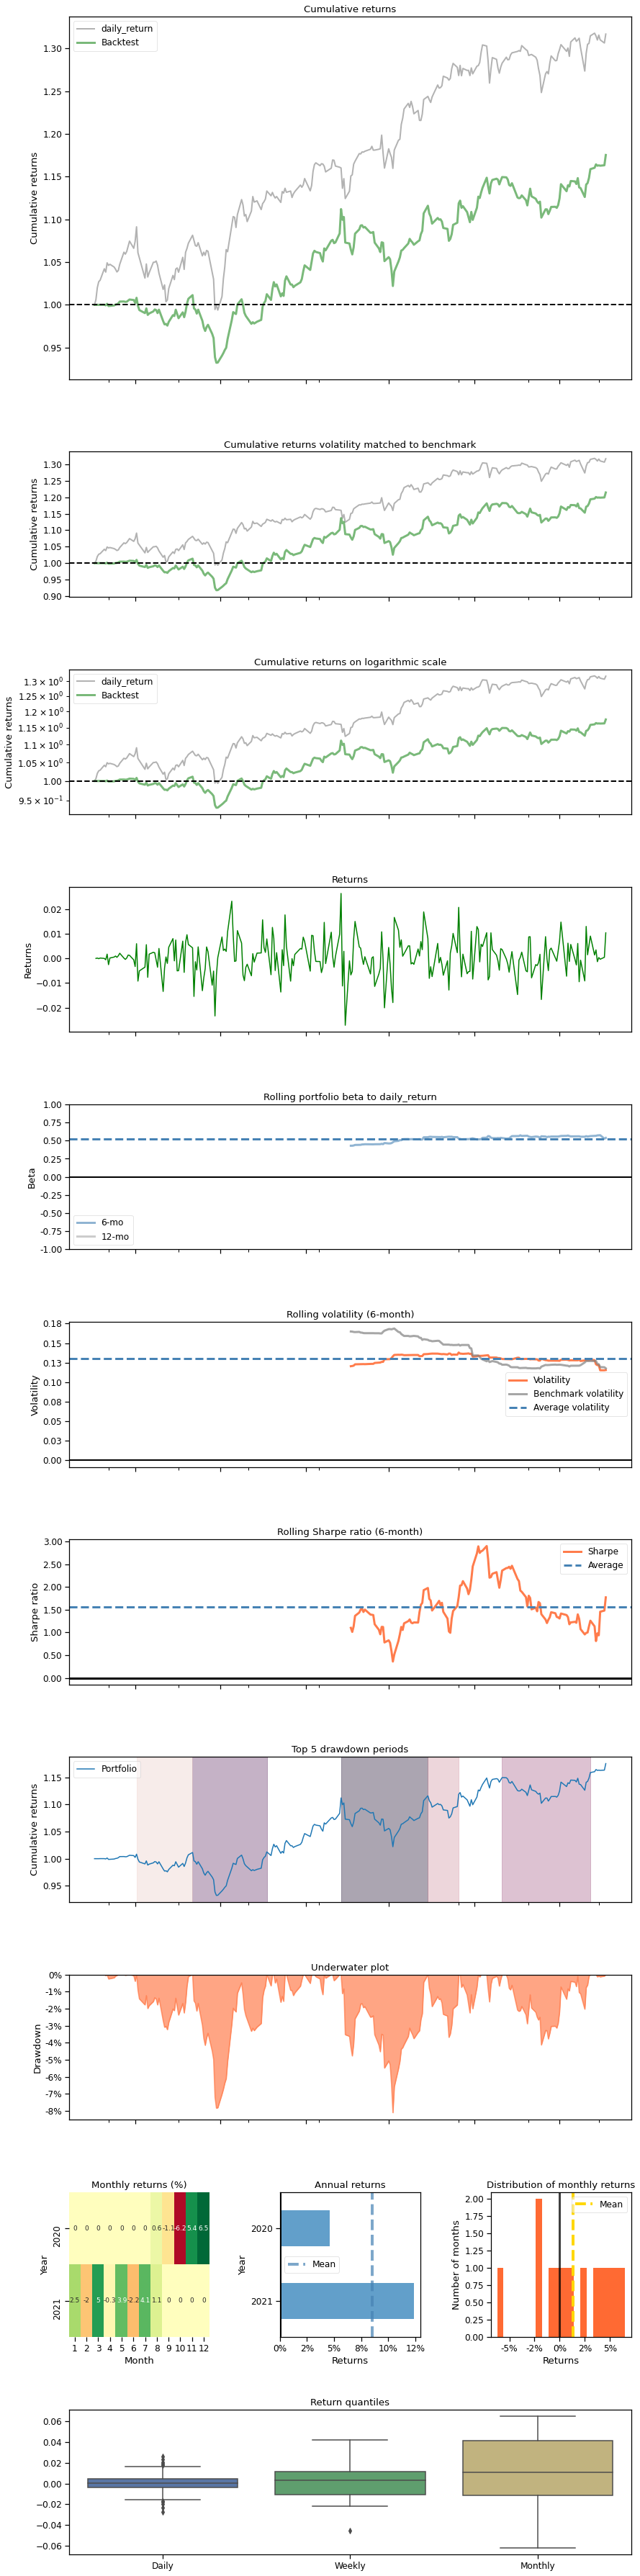

In [67]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_erl, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_erl.loc[0,'date'],
             baseline_end = account_value_erl.loc[len(account_value_erl)-1,'date'])

## RLlib

### Train

In [ ]:
#demo for rllib
train(start_date = TEST_START_DATE, 
      end_date = TEST_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='rllib', 
      env=env, 
      agent='ppo', 
      cwd='./test_ppo'
      ,total_episodes=100)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

2021-08-18 13:47:10,349	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-18 13:47:21,858	INFO trainer.py:706 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-08-18 13:47:21,860	INFO trainer.py:720 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-08-18 13:47:38,993	INFO trainable.py:109 -- Trainable.setup took 17.138 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


### Test

In [ ]:
account_value_rllib = test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = config.DOW_30_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST,
     drl_lib='rllib', 
     env=env, 
     agent='ppo', 
     cwd='./test_ppo/checkpoint_000100/checkpoint-100')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

2021-08-18 14:24:22,130	INFO trainable.py:109 -- Trainable.setup took 19.542 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-08-18 14:24:22,331	INFO trainable.py:383 -- Restored on 172.28.0.2 from checkpoint: ./test_ppo/checkpoint_000100/checkpoint-100
2021-08-18 14:24:22,339	INFO trainable.py:390 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 2031.5027058124542, '_episodes_total': 1586}


Restoring from checkpoint path ./test_ppo/checkpoint_000100/checkpoint-100
episode return: 1.7326374529744506
Test Finished!


In [ ]:
len(account_value_rllib)

255

### Plot

In [ ]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (254, 9)
Annual return          0.302105
Cumulative returns     0.304836
Annual volatility      0.143039
Sharpe ratio           1.925145
Calmar ratio           3.382743
Stability              0.935738
Max drawdown          -0.089308
Omega ratio            1.381054
Sortino ratio          2.847623
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.074665
Daily value at risk   -0.016928
dtype: float64


In [ ]:
len(baseline_df.date)

254

In [ ]:
account_value_rllib = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_rllib[0:len(account_value_rllib)-1]})

In [ ]:
perf_stats_all = backtest_stats(account_value=account_value_rllib)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.725243
Cumulative returns     0.732726
Annual volatility      0.210236
Sharpe ratio           2.711412
Calmar ratio           7.819859
Stability              0.955615
Max drawdown          -0.092744
Omega ratio            1.572524
Sortino ratio          4.526614
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.091560
Daily value at risk   -0.024225
dtype: float64


In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_rllib, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_rllib.loc[0,'date'],
             baseline_end = account_value_rllib.loc[len(account_value_rllib)-1,'date'])

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


<Figure size 1008x5184 with 13 Axes>


## Stable-baselines3

### Train

In [64]:
#demo for stable-baselines3
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='stable_baselines3', 
      env=env, 
      agent='ppo', 
      cwd='./test_ppo',
      total_timesteps=20000)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

ValueError: ignored

### Test

In [ ]:
account_value_sb3=test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = config.DOW_30_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST, 
     drl_lib='stable_baselines3', 
     env=env, 
     agent='ppo', 
     cwd='./test_ppo.zip')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
len(account_value_sb3)

255

### Plot

In [ ]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (254, 9)
Annual return          0.302105
Cumulative returns     0.304836
Annual volatility      0.143039
Sharpe ratio           1.925145
Calmar ratio           3.382743
Stability              0.935738
Max drawdown          -0.089308
Omega ratio            1.381054
Sortino ratio          2.847623
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.074665
Daily value at risk   -0.016928
dtype: float64


In [ ]:
account_value_sb3 = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_sb3[0:len(account_value_sb3)-1]})

In [ ]:
perf_stats_all = backtest_stats(account_value=account_value_sb3)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.254258
Cumulative returns     0.256515
Annual volatility      0.185498
Sharpe ratio           1.318909
Calmar ratio           2.670679
Stability              0.879340
Max drawdown          -0.095203
Omega ratio            1.248198
Sortino ratio          1.996820
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.066012
Daily value at risk   -0.022400
dtype: float64


In [ ]:
account_value_sb3.tail()

,date,account_value
249,2021-07-29,1.273393e+06
250,2021-07-30,1.262119e+06
251,2021-08-02,1.256096e+06
252,2021-08-03,1.266162e+06
253,2021-08-04,1.256515e+06


In [ ]:
print("==============Compare to DJIA===========")
#%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_sb3, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_sb3.loc[0,'date'],
             baseline_end = account_value_sb3.loc[len(account_value_sb3)-1,'date'])

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



<Figure size 1008x5184 with 13 Axes>


## Plotly

In [ ]:
baseline_df

,date,open,high,low,close,adjcp,volume,tic,day
0,2020-08-03,26542.320312,26707.259766,26534.380859,26664.400391,26664.400391,439380000,^DJI,0
1,2020-08-04,26664.609375,26832.720703,26597.820312,26828.470703,26828.470703,346350000,^DJI,1
2,2020-08-05,26924.779297,27221.669922,26924.779297,27201.519531,27201.519531,366000000,^DJI,2
3,2020-08-06,27170.820312,27394.099609,27145.250000,27386.980469,27386.980469,322460000,^DJI,3
4,2020-08-07,27321.679688,27456.240234,27223.550781,27433.480469,27433.480469,321170000,^DJI,4
...,...,...,...,...,...,...,...,...,...
249,2021-07-29,34985.988281,35171.519531,34985.988281,35084.531250,35084.531250,222680000,^DJI,3
250,2021-07-30,35013.261719,35106.300781,34871.128906,34935.468750,34935.468750,276410000,^DJI,4
251,2021-08-02,34968.558594,35192.109375,34808.199219,34838.160156,34838.160156,238620000,^DJI,0
252,2021-08-03,34864.101562,35120.941406,34714.328125,35116.398438,35116.398438,259820000,^DJI,1


In [ ]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [ ]:
account_value_rllib.head()

,date,account_value
0,2020-08-03,1.000000e+06
1,2020-08-04,9.998989e+05
2,2020-08-05,1.001804e+06
3,2020-08-06,1.001982e+06
4,2020-08-07,1.004149e+06


In [ ]:
daily_return = account_value_sb3.copy()
daily_return['sb3_return'] = account_value_sb3.account_value.pct_change()
daily_return['erl_return'] = account_value_erl.account_value.pct_change()
daily_return['rllib_return'] = account_value_rllib.account_value.pct_change()
daily_return['djia_return'] = baseline_df.adjcp.pct_change()


In [ ]:
daily_return.head()

,date,account_value,sb3_return,erl_return,rllib_return,djia_return
0,2020-08-03,1.000000e+06,NaN,NaN,NaN,NaN
1,2020-08-04,9.998347e+05,-0.000165,-0.000065,-0.000101,0.006153
2,2020-08-05,1.002510e+06,0.002676,0.000870,0.001905,0.013905
3,2020-08-06,1.002955e+06,0.000444,0.000770,0.000178,0.006818
4,2020-08-07,1.002987e+06,0.000032,0.001084,0.002163,0.001698


In [ ]:
daily_return.to_csv('daily_return_erl_sb3_rllib.csv',index=False)
#daily_return = pd.read_csv('daily_return_erl_sb3_rllib.csv')

In [ ]:
rllib_cumpod =(daily_return.rllib_return+1).cumprod()-1
sb3_cumpod =(daily_return.sb3_return+1).cumprod()-1
erl_cumpod =(daily_return.erl_return+1).cumprod()-1
dji_cumpod =(daily_return.djia_return+1).cumprod()-1

In [ ]:
time_ind = pd.Series(daily_return.date)

In [ ]:
trace0_portfolio = go.Scatter(x = time_ind, y = rllib_cumpod, mode = 'lines', name = 'RLlib')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = sb3_cumpod, mode = 'lines', name = 'Stablebaselines3')
trace3_portfolio = go.Scatter(x = time_ind, y = erl_cumpod, mode = 'lines', name = 'ElegantRL')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [ ]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

#fig.add_trace(trace1_portfolio)

#fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()